In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [27]:



import pandas as pd

# Read the dataset from a file
dataset_file_path = 'exp_bangla.txt'  # Replace with the actual file path
with open(dataset_file_path, 'r', encoding='utf-8') as file:
    conversations = file.read().split('\n')

# Separate questions and answers
questions = []
answers = []

for conversation in conversations:
    parts = conversation.split('  ')
    if len(parts) == 2:  # Ensure there are both questions and answers
        questions.append(parts[0].strip())
        answers.append(parts[1].strip())

# Create DataFrame
df = pd.DataFrame({'question': questions, 'answer': answers})

# Save to CSV
output_csv_path = 'output_dataset_bengali.csv'
df.to_csv(output_csv_path, index=False, sep='\t')

# Display the DataFrame
print(f'Dataframe size: {len(df)}')
df.head(10)


Dataframe size: 2


,question,answer
0,"হাই, আপনি কেমন আছেন?",আমি ভালো আছি । আপনি কেমন আছেন?
1,আমি ঠিক আছি । আপনি কেমন আছেন?,আমি বেশ ভালো আছি । জিজ্ঞাসা করার জন্য ধন্যবাদ ।


Data Preprocessing

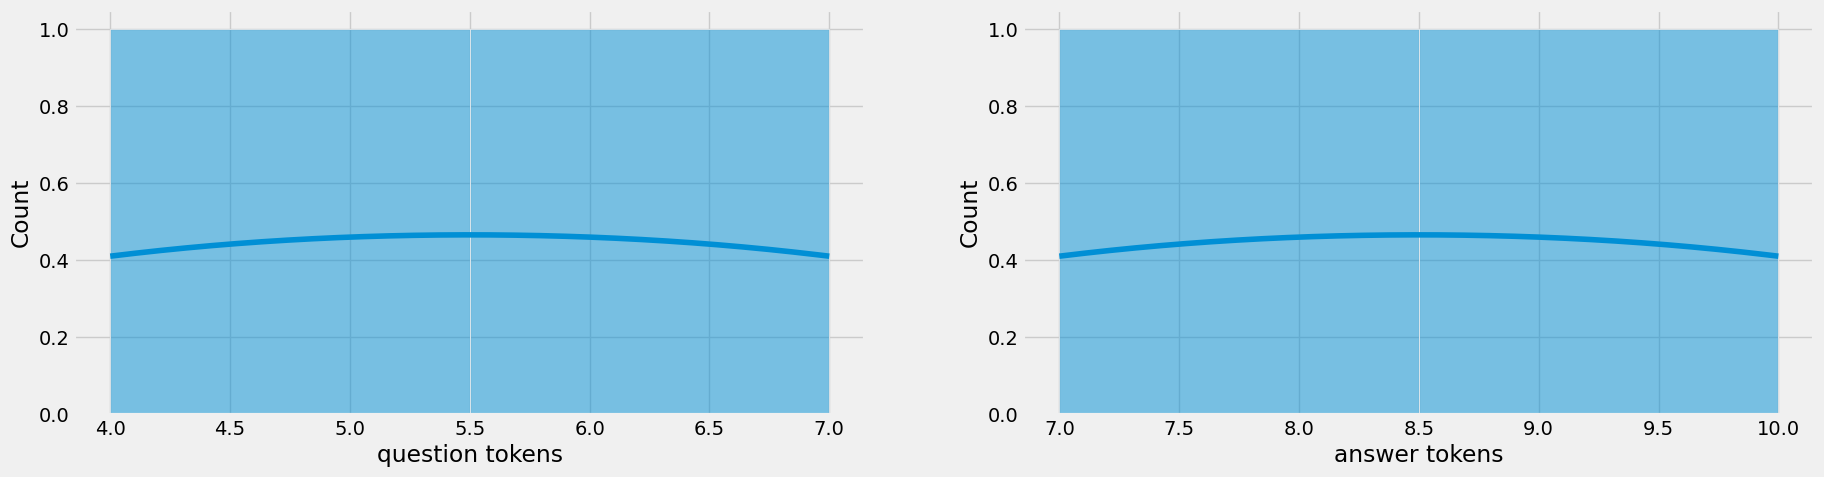

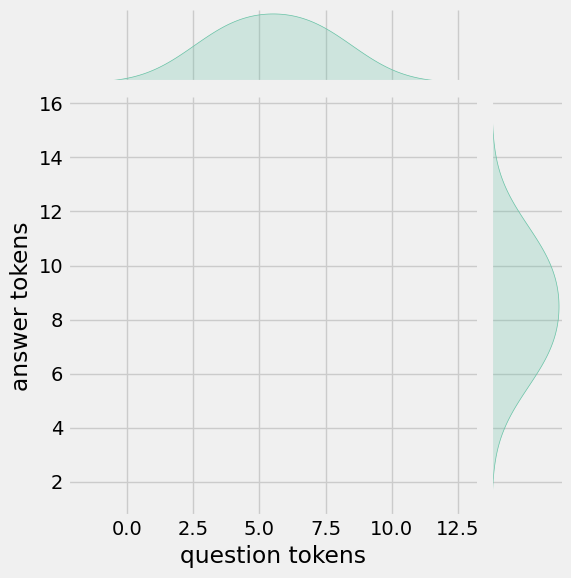

In [28]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['answer tokens'],data=df,kde=True,ax=ax[1])
sns.jointplot(x='question tokens',y='answer tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

Text Cleaning



In [29]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'

df.head(10)

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,"হাই, আপনি কেমন আছেন?",আমি ভালো আছি । আপনি কেমন আছেন?,"হাই , আপনি কেমন আছেন ?",আমি ভালো আছি । আপনি কেমন আছেন ? <end>,<start> আমি ভালো আছি । আপনি কেমন আছেন ? <end>
1,আমি ঠিক আছি । আপনি কেমন আছেন?,আমি বেশ ভালো আছি । জিজ্ঞাসা করার জন্য ধন্যবাদ ।,আমি ঠিক আছি । আপনি কেমন আছেন ?,আমি বেশ ভালো আছি । জিজ্ঞাসা করার জন্য ধন্যবাদ ...,<start> আমি বেশ ভালো আছি । জিজ্ঞাসা করার জন্য ...


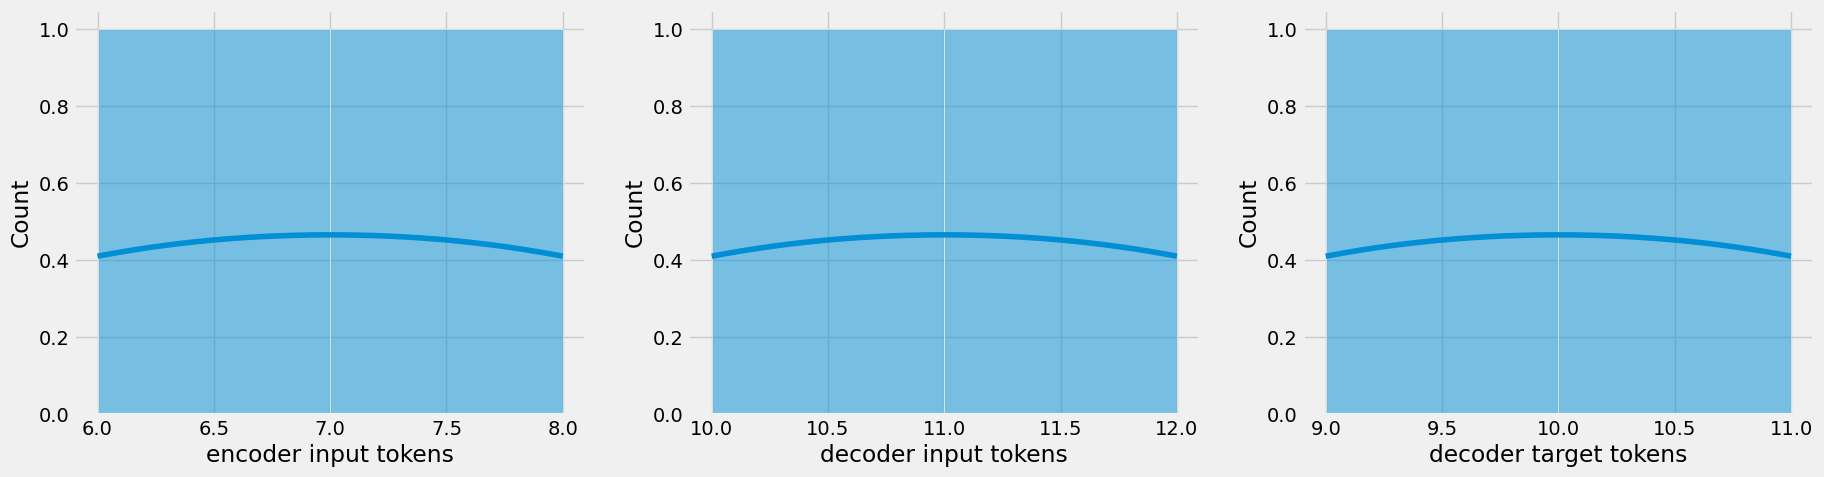

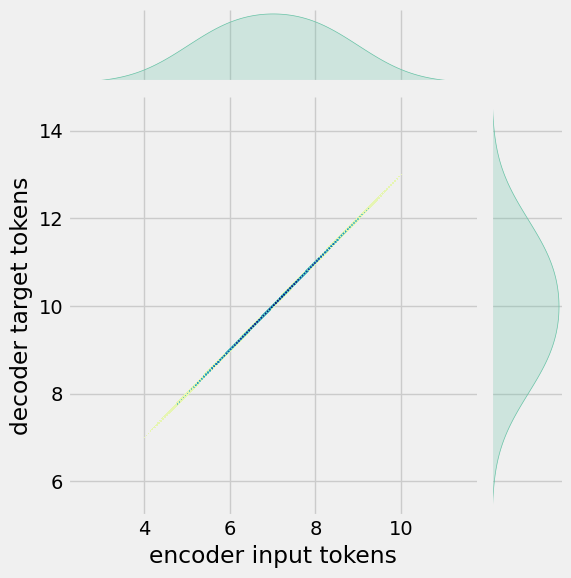

In [30]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
# plt.show()

In [31]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
df.head(10)

After preprocessing: আমি ঠিক আছি । আপনি কেমন আছেন ? 
Max encoder input length: 8
Max decoder input length: 12
Max decoder target length: 11


,encoder_inputs,decoder_targets,decoder_inputs
0,"হাই , আপনি কেমন আছেন ?",আমি ভালো আছি । আপনি কেমন আছেন ? <end>,<start> আমি ভালো আছি । আপনি কেমন আছেন ? <end>
1,আমি ঠিক আছি । আপনি কেমন আছেন ?,আমি বেশ ভালো আছি । জিজ্ঞাসা করার জন্য ধন্যবাদ ...,<start> আমি বেশ ভালো আছি । জিজ্ঞাসা করার জন্য ...


Tokenization

In [32]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 20
['', '[UNK]', '।', '<end>', 'কেমন', 'আমি', 'আপনি', 'আছেন', 'আছি', '?', 'ভালো', '<start>']


In [33]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [ 1 19  1  1  1  9  0  0  0  0]
Encoder input shape: (2, 30)
Decoder input shape: (2, 30)
Decoder target shape: (2, 30)


In [34]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [12 19  6  4  7  9  0  0  0  0  0  0] ...
Decoder input: [11  5 10  8  2  6  4  7  9  3  0  0] ...
Decoder target: [ 5 10  8  2  6  4  7  9  3  0  0  0] ...


In [35]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 1
Number of training data: 149
Number of validation batches: 0
Number of validation data: 0
Encoder Input shape (with batches): (1, 30)
Decoder Input shape (with batches): (1, 30)
Target Output shape (with batches): (1, 30)


**Build Models**

Build Encoder

In [36]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )

    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
 array([[ 3.10134928e-04,  3.51252735e-01,  2.55544215e-01,
         -2.27710411e-01, -2.79265970e-01, -3.44261646e-01,
         -1.60831273e-01, -9.14187580e-02,  2.07629606e-01,
         -4.24502008e-02, -8.12691301e-02,  1.64058954e-01,
          8.53093639e-02,  2.30601411e-02,  1.47904202e-01,
         -1.60075679e-01,  5.72788976e-02, -2.67887414e-02,
         -4.68479209e-02,  1.79387614e-01, -1.15700141e-01,
         -6.05904311e-02,  8.19067210e-02, -2.62107670e-01,
         -3.76468480e-01, -1.48359030e-01,  1.34673163e-01,
          8.66908357e-02, -3.44597638e-01,  8.75121914e-03,
         -1.11263186e-01,  1.18573561e-01,  1.10954091e-01,
          1.55189767e-01,  9.03303996e-02,  6.78371191e-02,
          2.09861934e-01, -1.01589382e-01, -2.37931143e-02,
         -3.63631129e-01,  1.65305004e-01, -2.47327045e-01,
          2.60959387e-01,  1.35401979e-01,  2.30193734e-01,
         -1.69356670e-02, -3.29129934e-01, -6.423

Build Decoder

In [37]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )

    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 20), dtype=float32, numpy=
array([[[8.48468840e-02, 7.75956456e-03, 7.68418014e-02, 5.85818617e-03,
         1.94750335e-02, 3.15601230e-02, 1.24702621e-02, 1.08327977e-01,
         9.31772515e-02, 2.73660999e-02, 2.53890604e-01, 1.05155893e-02,
         4.12420630e-02, 1.24023799e-02, 7.11207390e-02, 2.10688962e-03,
         2.23814640e-02, 6.89512193e-02, 4.41222563e-02, 5.58362389e-03],
        [9.64503810e-02, 8.12525861e-03, 6.59257025e-02, 7.31636817e-03,
         2.26759501e-02, 8.03537816e-02, 3.81538249e-03, 6.96004108e-02,
         9.07918587e-02, 1.64012328e-01, 1.15281723e-01, 1.90328844e-02,
         1.40954465e-01, 2.07912526e-03, 5.72005473e-03, 1.76259708e-02,
         3.13395411e-02, 5.43963201e-02, 4.09340020e-03, 4.09034867e-04],
        [6.29557669e-02, 2.77400040e-03, 1.45548778e-02, 4.45642322e-02,
         2.81263471e-01, 9.00160149e-03, 5.93937794e-03, 1.33909658e-02,
         6.33971840e-02, 2.34088570e-01, 4.60907742e-02, 1.21184913e-

Build Training Model

In [38]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)

    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics

    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [39]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(1, 30, 20), dtype=float32, numpy=
array([[[8.48468840e-02, 7.75956456e-03, 7.68418014e-02, 5.85818617e-03,
         1.94750335e-02, 3.15601230e-02, 1.24702621e-02, 1.08327977e-01,
         9.31772515e-02, 2.73660999e-02, 2.53890604e-01, 1.05155893e-02,
         4.12420630e-02, 1.24023799e-02, 7.11207390e-02, 2.10688962e-03,
         2.23814640e-02, 6.89512193e-02, 4.41222563e-02, 5.58362389e-03],
        [9.64503810e-02, 8.12525861e-03, 6.59257025e-02, 7.31636817e-03,
         2.26759501e-02, 8.03537816e-02, 3.81538249e-03, 6.96004108e-02,
         9.07918587e-02, 1.64012328e-01, 1.15281723e-01, 1.90328844e-02,
         1.40954465e-01, 2.07912526e-03, 5.72005473e-03, 1.76259708e-02,
         3.13395411e-02, 5.43963201e-02, 4.09340020e-03, 4.09034867e-04],
        [6.29557669e-02, 2.77400040e-03, 1.45548778e-02, 4.45642322e-02,
         2.81263471e-01, 9.00160149e-03, 5.93937794e-03, 1.33909658e-02,
         6.33971840e-02, 2.34088570e-01, 4.60907742e-02, 1.21184913e-

Train Model

In [40]:
history=model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

# Assuming train_data and val_data are properly prepared datasets

# history = model.fit(
#     train_data,
#     epochs=10,
#     validation_data=val_data,
#     callbacks=[...],  # Any callbacks you might be using
# )

# Display the training history
print(history.history)


Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.2393 - accuracy: 0.1111

ValueError: ignored